## Comparing the PIR and HARK solution

- author: Tao Wang
- date: Feb 2022
- this is a companion notebook to the paper "Perceived income risks"

In [7]:
import numpy as np
import pandas as pd
from quantecon.optimize import brent_max, brentq
from interpolation import interp, mlinterp
from scipy import interpolate
import numba as nb
from numba import jit,njit, float64, int64, boolean
from numba.experimental import jitclass
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon import MarkovChain
import quantecon as qe 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from time import time
#from HARK.utilities import make_grid_exp_mult
from scipy import sparse as sp
import scipy.sparse.linalg
from scipy import linalg as lg 
from numba.typed import List
from Utility import cal_ss_2markov

In [8]:
## figure plotting configurations

mp.rc('xtick', labelsize=11) 
mp.rc('ytick', labelsize=11) 

mp.rc('legend',fontsize=11)
plt.rc('font',size=11) 

In [9]:
from SolveLifeCycle import LifeCycle, EGM, solve_model_iter
from PrepareParameters import life_cycle_paras_y as inf_paras

### parameters 

In [22]:
inf_paras['G'] =  np.ones_like(inf_paras['G'])
inf_paras['unemp_insurance'] = 0.0
inf_paras['P'] = np.array([[0.9,0.1],[0.2,0.8]])

grid_max = 5.0
grid_size = 50

In [23]:
inf_mkv = LifeCycle(U = inf_paras['U'], ## transitory ue risk
                    unemp_insurance = inf_paras['unemp_insurance'],
                    pension = inf_paras['pension'], ## pension
                    sigma_n = inf_paras['σ_ψ'], # permanent 
                    sigma_eps = inf_paras['σ_θ'], # transitory 
                    P = inf_paras['P'],   ## transitory probability of markov state z
                    z_val = inf_paras['z_val'], ## markov state from low to high  
                    x = 0.0,           ## MA(1) coefficient of non-permanent inocme shocks
                    ue_markov = True,   
                    adjust_prob = 1.0,
                    sigma_p_init = inf_paras['σ_ψ_init'],
                    init_b = inf_paras['init_b'],
                    ## subjective risk prifile 
                    sigma_n_2mkv = inf_paras['σ_ψ_2mkv'],  ## permanent risks in 2 markov states
                    sigma_eps_2mkv = inf_paras['σ_θ_2mkv'],  ## transitory risks in 2 markov states
                    λ = inf_paras['λ'],  ## tax rate
                    λ_SS = inf_paras['λ_SS'], ## social tax rate
                    transfer = inf_paras['transfer'],  ## transfer 
                    bequest_ratio = inf_paras['bequest_ratio'],
                    LivPrb = inf_paras['LivPrb'],       ## living probability 
                    ## life cycle 
                    T = inf_paras['T'],
                    L = inf_paras['L'],
                    G = inf_paras['G'],
                    #YPath = np.cumprod(G),
                    ## other parameters 
                    ρ = inf_paras['ρ'],     ## relative risk aversion  
                    β = inf_paras['β'],    ## discount factor
                    R = inf_paras['R'],           ## interest factor 
                    W = inf_paras['W'],            ## Wage rate
                    ## subjective models 
                    theta = 0.0, ## extrapolation parameter 
                    ## no persistent state
                    b_y = 0.0,
                    ## wether to have zero borrowing constraint 
                    borrowing_cstr = True,
                    ## a grids 
                    grid_max = 20,
                    grid_size = 200,
    )

Error at iteration 50 is 0.0017409226110949305.
Error at iteration 100 is 5.517104514152216e-05.
Error at iteration 150 is 1.957220169268581e-06.

Converged in 161 iterations.
Time taken, in seconds: 338.8171441555023


Text(0.5, 1.0, 'Inifite horizon solution')

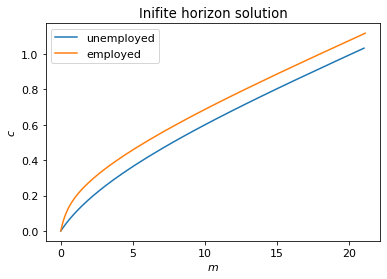

In [6]:
## initial consumption functions 

k = len(inf_mkv.s_grid)
k2 =len(inf_mkv.eps_grid)

n = len(inf_mkv.P)
σ_init = np.empty((k,k2,n))
a_init = np.empty((k,k2,n))

for z in range(n):
    for j in range(k2):
        a_init[:,j,z] = inf_mkv.s_grid
        σ_init[:,j,z] = 0.1*a_init[:,j,z]

t_start = time()

a_inf_star, σ_inf_star = solve_model_iter(inf_mkv,
                                          a_init,
                                          σ_init)
t_finish = time()

print("Time taken, in seconds: "+ str(t_finish - t_start))   


## plot c func 

eps = 10 ## a random number 
m_plt_u, c_plt_u = a_inf_star[:,eps,0],σ_inf_star[:,eps,0] 
m_plt_e, c_plt_e = a_inf_star[:,eps,1], σ_inf_star[:,eps,1]
plt.plot(m_plt_u,
         c_plt_u,
         label = 'unemployed',
        )
plt.plot(m_plt_e,
         c_plt_e,
         label = 'employed',
        )
plt.legend()
plt.xlabel(r'$m$')
plt.ylabel(r'$c$')
plt.title('Inifite horizon solution')

## Solving the same model with HARK


In [10]:
from copy import copy
from HARK.ConsumptionSaving.ConsMarkovModel import MarkovConsumerType
from HARK.distribution import DiscreteDistribution
from HARK.ConsumptionSaving.ConsIndShockModel import init_lifecycle
from HARK.ConsumptionSaving.ConsIndShockModel import init_idiosyncratic_shocks
from HARK.utilities import plot_funcs

In [8]:
## for infinite horizon 
hark_mkv_para = copy(init_idiosyncratic_shocks)
hark_mkv_para["MrkvArray"] = [inf_paras['P']]
hark_mkv_para["UnempPrb"] = inf_paras['U']  # to make income distribution when employed
hark_mkv_para["global_markov"] = False
hark_mkv_para['CRRA'] = inf_paras['ρ']
hark_mkv_para['Rfree'] = inf_paras['R']
hark_mkv_para['LivPrb'] = [inf_paras['LivPrb']]
hark_mkv_para['PermGroFac'] = [1.0]
hark_mkv_para['PermShkStd'] = [inf_paras['σ_ψ']]
hark_mkv_para['TranShkStd'] = [inf_paras['σ_θ']]
hark_mkv_para['DiscFac'] = inf_paras['β']
hark_mkv_para['aXtraMax'] = grid_max
hark_mkv_para['aXtraCount'] = grid_size-1

In [9]:
print('HARK parameterization',str(hark_mkv_para))
print('PIR parameterization',str(inf_paras))

HARK parameterization {'CRRA': 1.0, 'Rfree': 1.01, 'DiscFac': 0.98, 'LivPrb': [0.99375], 'PermGroFac': [1.0], 'BoroCnstArt': 0.0, 'MaxKinks': 400, 'AgentCount': 10000, 'aNrmInitMean': 0.0, 'aNrmInitStd': 1.0, 'pLvlInitMean': 0.0, 'pLvlInitStd': 0.0, 'PermGroFacAgg': 1.0, 'T_age': None, 'T_cycle': 1, 'aXtraMin': 0.001, 'aXtraMax': 5.0, 'aXtraNestFac': 3, 'aXtraCount': 49, 'aXtraExtra': [None], 'PermShkStd': [0.15], 'PermShkCount': 7, 'TranShkStd': [0.1], 'TranShkCount': 7, 'UnempPrb': 0.0, 'UnempPrbRet': 0.005, 'IncUnemp': 0.3, 'IncUnempRet': 0.0, 'tax_rate': 0.0, 'T_retire': 0, 'vFuncBool': False, 'CubicBool': False, 'MrkvArray': [array([[0.9, 0.1],
       [0.2, 0.8]])], 'global_markov': False}
PIR parameterization {'ρ': 1.0, 'β': 0.98, 'P': array([[0.9, 0.1],
       [0.2, 0.8]]), 'z_val': array([0., 1.]), 'σ_ψ': 0.15, 'σ_θ': 0.1, 'U': 0.0, 'LivPrb': 0.99375, 'R': 1.01, 'W': 1.0, 'T': 40, 'L': 60, 'G': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.

In [10]:
hark_mkv = MarkovConsumerType(**hark_mkv_para)
hark_mkv.cycles = 0
hark_mkv.vFuncBool = False  # for easy toggling here

In [11]:
# Interest factor, permanent growth rates, and survival probabilities are constant arrays
hark_mkv.assign_parameters(Rfree = np.array(2 * [hark_mkv.Rfree]))
hark_mkv.PermGroFac = [
    np.array(2 * hark_mkv.PermGroFac)
]
hark_mkv.LivPrb = [hark_mkv.LivPrb * np.ones(2)]

In [12]:
# Replace the default (lognormal) income distribution with a custom one
employed_income_dist = DiscreteDistribution(np.ones(1), [np.ones(1), np.ones(1)])  # Definitely get income
unemployed_income_dist = DiscreteDistribution(np.ones(1), [np.ones(1), np.zeros(1)]) # Definitely don't
hark_mkv.IncShkDstn = [
    [
        unemployed_income_dist,
        employed_income_dist
    ]
]

Solving a Markov consumer with serially correlated unemployment took 0.1097710132598877 seconds.
Consumption functions for each discrete state:


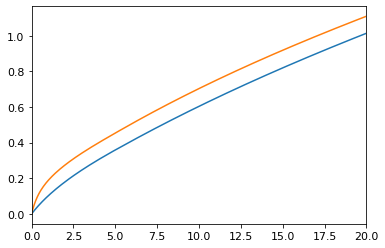

In [13]:
## solve the model 

start_time = time()
hark_mkv.solve()
end_time = time()
print(
    "Solving a Markov consumer with serially correlated unemployment took "
    + str(end_time - start_time)
    + " seconds."
)
print("Consumption functions for each discrete state:")
plot_funcs(hark_mkv.solution[0].cFunc, 0, 20)
if hark_mkv.vFuncBool:
    print("Value functions for each discrete state:")
    plot_funcs(hark_mkv.solution[0].vFunc, 5, 20)

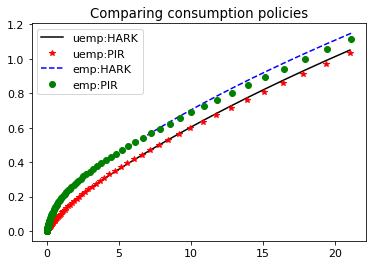

In [14]:
## compare the solutions 

## get the HARK c  
c_u_HARK = hark_mkv.solution[0].cFunc[0](m_plt_u)
c_e_HARK = hark_mkv.solution[0].cFunc[1](m_plt_e)

plt.title('Comparing consumption policies')
plt.plot(m_plt_u,c_u_HARK,'k-',label='uemp:HARK')
plt.plot(m_plt_u,c_plt_u,'r*',label='uemp:PIR')
plt.plot(m_plt_e,c_e_HARK,'b--',label='emp:HARK')
plt.plot(m_plt_e,c_plt_e,'go',label='emp:PIR')
plt.legend(loc=0)

## Wealth distribution over life cycle 

In [24]:
lc_paras

{'ρ': 1.0,
 'β': 0.98,
 'P': array([[0.9, 0.1],
        [0.2, 0.8]]),
 'z_val': array([0., 1.]),
 'σ_ψ': 0.15,
 'σ_θ': 0.1,
 'U': 0.0,
 'LivPrb': 0.99375,
 'R': 1.01,
 'W': 1.0,
 'T': 40,
 'L': 60,
 'G': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'unemp_insurance': 0.0,
 'pension': 1.0,
 'σ_ψ_init': 0.6285209184601319,
 'init_b': 0.5540657379463796,
 'λ': 0.0,
 'λ_SS': 0.0,
 'transfer': 0.0,
 'bequest_ratio': 0.0,
 'κ': 1.719786711116489,
 'q': 0.9999949729217684,
 'p': 0.9999949729217684,
 'σ_ψ_2mkv': array([0.30487402, 0.97615849]),
 'σ_θ_2mkv': array([0.00738643, 0.02365018]),
 'mho_2mkv': array([0.31532124, 0.99885345]),
 'E_2mkv': array([0.31808566, 0.99884752])}

In [25]:
## for life cycle 
init_life_cycle_new = copy(init_lifecycle)
lc_paras = inf_paras

init_life_cycle_new['T_cycle'] = lc_paras['L']-1   ## minus 1 because T_cycle is nb periods in a life cycle - 1 in HARK 
init_life_cycle_new['CRRA'] = lc_paras['ρ']
init_life_cycle_new['T_retire'] = lc_paras['T']
init_life_cycle_new['Rfree'] = lc_paras['R']
init_life_cycle_new['LivPrb'] = [lc_paras['LivPrb']]*init_life_cycle_new['T_cycle']
init_life_cycle_new['PermGroFac'] = lc_paras['G']
init_life_cycle_new['PermShkStd'] = [lc_paras['σ_ψ']]*init_life_cycle_new['T_cycle']
init_life_cycle_new['TranShkStd'] = [lc_paras['σ_θ']]*init_life_cycle_new['T_cycle']
init_life_cycle_new['DiscFac'] = lc_paras['β']
init_life_cycle_new['PermGroFacAgg'] = 1.0
init_life_cycle_new['aNrmInitMean']= lc_paras['init_b']
init_life_cycle_new['aNrmInitStd']= 0.0
init_life_cycle_new['pLvlInitMean']= 1.0
init_life_cycle_new['pLvlInitStd']= lc_paras['σ_ψ_init']
init_life_cycle_new["UnempPrb"] = lc_paras['U']  # to make income distribution when employed

#init_life_cycle_new['aXtraMin'] = a_min+0.00001
#init_life_cycle_new['aXtraMax'] = a_max
#init_life_cycle_new['aXtraCount'] = 800

#init_life_cycle_new["MrkvArray"] = [lc_paras['P']]
#init_life_cycle_new["global_markov"] = False

"""
LifeCycleType = MarkovConsumerType(**init_life_cycle_new)

LifeCycleType.cycles = 1 ## life cycle problem instead of infinite horizon
LifeCycleType.vFuncBool = False  ## no need to calculate the value for the purpose here 
"""

'\nLifeCycleType = MarkovConsumerType(**init_life_cycle_new)\n\nLifeCycleType.cycles = 1 ## life cycle problem instead of infinite horizon\nLifeCycleType.vFuncBool = False  ## no need to calculate the value for the purpose here \n'

In [26]:
import HARK.ConsumptionSaving.ConsIndShockModel as HARK_model         # The consumption-saving micro model
from HARK.utilities import plot_funcs_der, plot_funcs              # Some tools

In [27]:
LifeCyclePop = HARK_model.IndShockConsumerType(**init_life_cycle_new)
LifeCyclePop.cycles = 1
LifeCyclePop.vFuncBool = False  # for easy toggling here

In [28]:
LifeCyclePop.solve()                            # Obtain consumption rules by age 
LifeCyclePop.unpack('cFunc')                      # Expose the consumption rules

# Which variables do we want to track
LifeCyclePop.track_vars = ['aNrm','pLvl','mNrm','cNrm','TranShk']

LifeCyclePop.T_sim = lc_paras['L']-1              # Nobody lives to be older than 145 years (=25+120)
LifeCyclePop.initialize_sim()                     # Construct the age-25 distribution of income and assets
LifeCyclePop.simulate()

/Users/tao/opt/anaconda3/envs/econ-ark/lib/python3.9/site-packages/HARK/core.py:871: RuntimeWarning: invalid value encountered in add
  self.history[var_name] = np.empty((self.T_sim, self.AgentCount)) + np.nan


{'aNrm': array([[1.75933448, 1.668137  , 1.668137  , ..., 1.56744811, 1.668137  ,
         1.85565089],
        [1.40750715, 1.7185982 , 1.57818243, ..., 1.57554329, 1.668137  ,
         1.83132862],
        [1.68139601, 1.45403046, 1.23313582, ..., 1.85990492, 1.85435485,
         2.1053309 ],
        ...,
        [1.82785935, 0.16627707, 0.16616134, ..., 0.17585811, 1.45238341,
         0.16586079],
        [2.0536408 , 0.13638995, 0.13632591, ..., 0.1416911 , 1.4592419 ,
         0.13615962],
        [2.43597715, 0.08900065, 0.088975  , ..., 0.0911243 , 1.53787121,
         0.08890838]]),
 'pLvl': array([[ 9.43475321,  3.54285931,  7.31071278, ...,  1.53191434,
          2.52921039,  1.45158615],
        [11.84960795,  3.50364938,  8.15227043, ...,  1.70825751,
          3.98741805,  1.43552099],
        [10.39477296,  4.40041945, 10.23886969, ...,  1.33561014,
          3.73137329,  1.34334163],
        ...,
        [ 6.04201397,  3.47778199, 15.19810788, ...,  0.56956476,
        

In [29]:
LifeCyclePop.history['aLvl'] = LifeCyclePop.history['aNrm']*LifeCyclePop.history['pLvl']
aGro41=LifeCyclePop.history['aLvl'][41]/LifeCyclePop.history['aLvl'][40]
aGro41NoU=aGro41[aGro41[:]>0.2] # Throw out extreme outliers
aGro41NoU = aGro41NoU[aGro41NoU[:]<2]

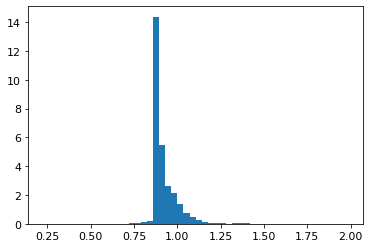

In [30]:
# Plot the distribution of growth rates of wealth between age 65 and 66 (=25 + 41)
n, bins, patches = plt.hist(aGro41NoU,50,density=True)

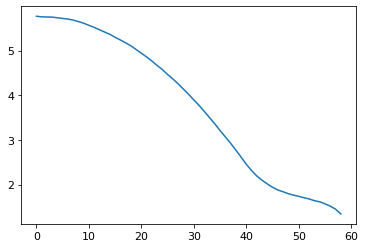

In [31]:
plt.plot(LifeCyclePop.history['aLvl'].mean(axis=1))

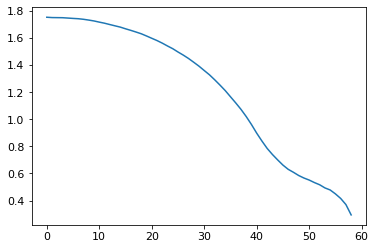

In [32]:
plt.plot(np.log(LifeCyclePop.history['aLvl'].mean(axis=1)))

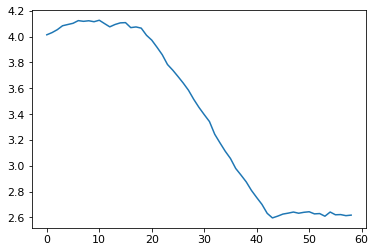

In [33]:
plt.plot(LifeCyclePop.history['aLvl'].std(axis=1))